# About the Data
Temperature sensor data of an internal component of a large, industrial mahcine. The first anomaly is a planned shutdown of the machine. The second anomaly is difficult to detect and directly led to the third anomaly, a catastrophic failure of the machine.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
%matplotlib inline
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing
from sklearn.svm import OneClassSVM
dataframe = pd.read_csv("machine_temperature_system_failure.csv")
dataframe.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


## Format the Timestamp

In [16]:
dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'])

## Plot the data
Lets see how the machine's temperature is varying with time

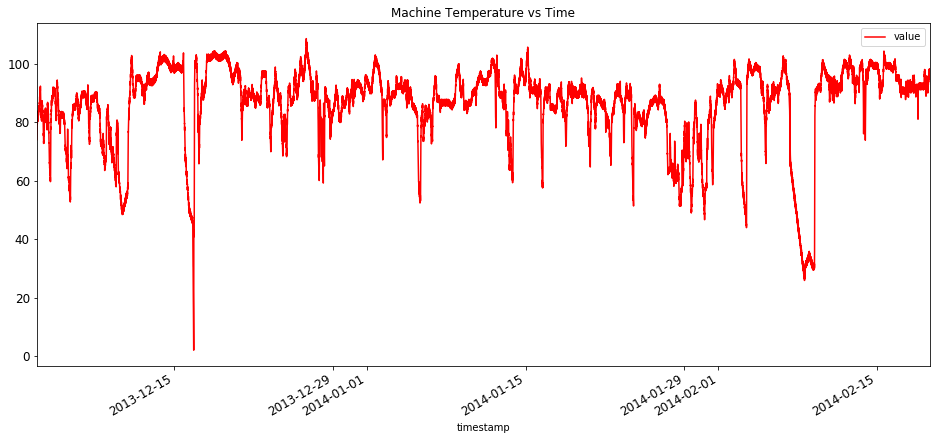

In [17]:
dataframe.plot(x='timestamp', y='value',figsize=(16,7), title= 'Machine Temperature vs Time',color='Red', fontsize=12)

# Feature Engineering - Create additional Columns 
*Hours - Denote hour of day*

*DayLight - Denote Day and Night*

*Day of The Week - MTWRFSS*

*WeekDay - To denote Weekday or Weekend*

In [32]:
dataframe['Hours'] = dataframe['timestamp'].dt.hour
dataframe['Daylight'] = ((dataframe['Hours'] >= 7) & (dataframe['Hours'] <= 22)).astype(int)
dataframe['DayOfTheWeek'] = dataframe['timestamp'].dt.dayofweek
dataframe['WeekDay'] = (dataframe['DayOfTheWeek'] < 5).astype(int)
dataframe.head()

,timestamp,value,Hours,Daylight,DayOfTheWeek,WeekDay,Categories,Time,anomalySVM
0,2013-12-02 21:15:00,73.967322,21,1,0,1,3,13860189,0
1,2013-12-02 21:20:00,74.935882,21,1,0,1,3,13860192,0
2,2013-12-02 21:25:00,76.124162,21,1,0,1,3,13860195,0
3,2013-12-02 21:30:00,78.140707,21,1,0,1,3,13860198,0
4,2013-12-02 21:35:00,79.329836,21,1,0,1,3,13860201,0


##  Create Categories - Feature Engineering
    WeekEndNight - Denotes weekend night
    WeekEndDay - Denotes weekend day
    WeekDayNight - Denotes weekday night
    WeekDayDay - Denotes weekday day
 

In [30]:
dataframe['Categories'] = dataframe['WeekDay']*2 + dataframe['Daylight']
a = dataframe.loc[dataframe['Categories'] == 0, 'value']
b = dataframe.loc[dataframe['Categories'] == 1, 'value']
c = dataframe.loc[dataframe['Categories'] == 2, 'value']
d = dataframe.loc[dataframe['Categories'] == 3, 'value']
dataframe.head()

,timestamp,value,Hours,Daylight,DayOfTheWeek,WeekDay,Categories,Time,anomalySVM
0,2013-12-02 21:15:00,73.967322,21,1,0,1,3,13860189,0
1,2013-12-02 21:20:00,74.935882,21,1,0,1,3,13860192,0
2,2013-12-02 21:25:00,76.124162,21,1,0,1,3,13860195,0
3,2013-12-02 21:30:00,78.140707,21,1,0,1,3,13860198,0
4,2013-12-02 21:35:00,79.329836,21,1,0,1,3,13860201,0


## Looking into the temperature all through the 4 categories created above 

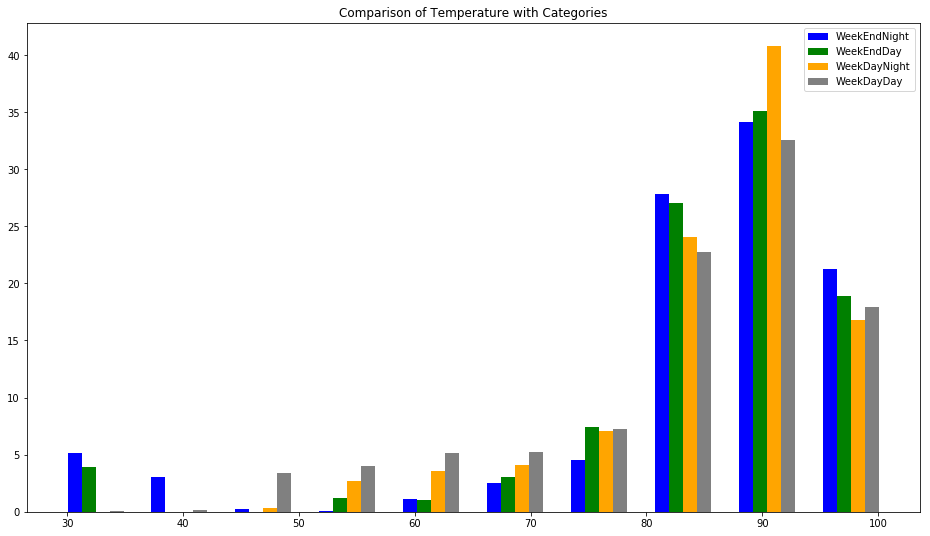

In [19]:
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)
width = (a_bins[1] - a_bins[0])/6
ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndDay')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='orange', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='gray', label ='WeekDayDay')
fig.set_size_inches(16,9)
plt.title("Comparison of Temperature with Categories")
plt.legend()
plt.show()

## Anomaly Detection - Isolation Forest

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


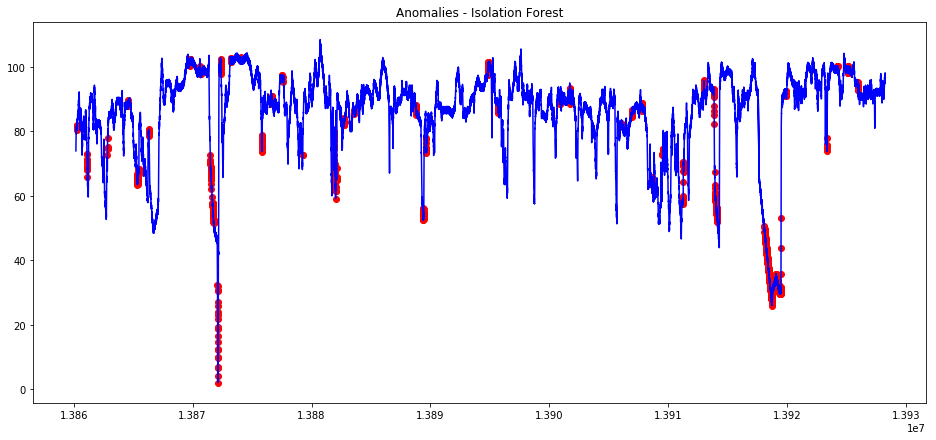

In [27]:
data = dataframe[['value', 'Hours', 'Daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
model =  IsolationForest(contamination = 0.05)
model.fit(data)
anomalyBasic = pd.Series(model.predict(data))
anomalyBasic = anomalyBasic.map( {1: 0, -1: 1} )
fig, ax = plt.subplots()
dataframe['Time'] = (dataframe['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

a = dataframe.loc[anomalyBasic == 1, ['Time', 'value']] #anomaly
fig.set_size_inches(16,7)
ax.plot(dataframe['Time'], dataframe['value'], color='blue')
ax.scatter(a['Time'],a['value'], color='red')
plt.title("Anomalies - Isolation Forest")
plt.show()

## Visualisation of anomaly with temperature repartition (viz 2)

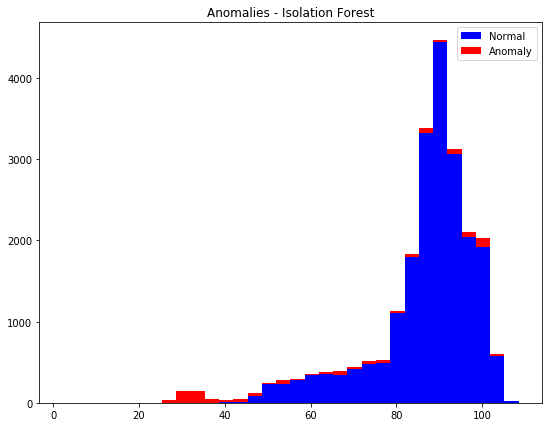

In [21]:
a = dataframe.loc[anomalyBasic == 0, 'value']
b = dataframe.loc[anomalyBasic == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['Normal', 'Anomaly'])
fig.set_size_inches(9,7)
plt.title("Anomalies - Isolation Forest")
plt.legend()
plt.show()

## Anomaly Detection - OneClassSVM

In [24]:
data = dataframe[['value', 'Hours', 'Daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
model =  OneClassSVM(nu=0.95 * 0.05)
data = pd.DataFrame(np_scaled)
model.fit(data)
dataframe['anomalySVM'] = pd.Series(model.predict(data))
dataframe['anomalySVM'] = dataframe['anomalySVM'].map( {1: 0, -1: 1} )
print(dataframe['anomalySVM'].value_counts())

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


0    21617
1     1078
Name: anomalySVM, dtype: int64


##  Visualisation of anomaly - OneClass SVM

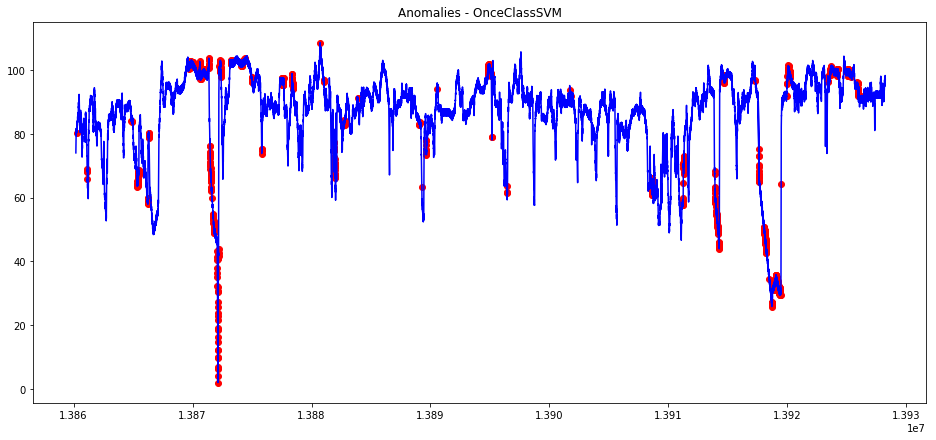

In [26]:
fig, ax = plt.subplots()
a = dataframe.loc[dataframe['anomalySVM'] == 1, ['Time', 'value']] #anomaly
fig.set_size_inches(16,7)
ax.plot(dataframe['Time'], dataframe['value'], color='blue')
ax.scatter(a['Time'],a['value'], color='red')
plt.title("Anomalies - OnceClassSVM")
plt.show()

##  Visualisation of anomaly - OneClassSVM 

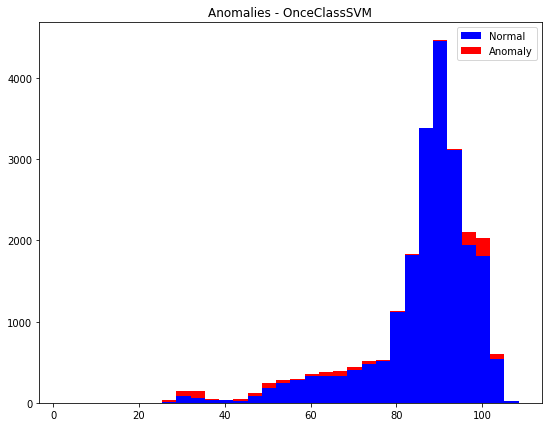

In [29]:
a = dataframe.loc[dataframe['anomalySVM'] == 0, 'value']
b = dataframe.loc[dataframe['anomalySVM'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['Normal', 'Anomaly'])
plt.title("Anomalies - OnceClassSVM")
fig.set_size_inches(9,7)
plt.legend()
plt.show()